In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
# Load the CSV file
file_path = "employee_skills_data.csv"
data = pd.read_csv(file_path)

In [4]:
# Convert the DataFrame to the required format
employees_with_ratings = []
for index, row in data.iterrows():
    employee_data = {
        "name": row["Employee ID"],
        "department": row["Department"],
        "experience": row["Total Experience (Years)"],
        "ds_experience": row["Data Science Experience (Years)"],
        "skills": {col: row[col] for col in data.columns if col not in ["Employee ID", "Department", "Total Experience (Years)", "Data Science Experience (Years)"]}
    }
    employees_with_ratings.append(employee_data)

# Preview the structured data
# employees_with_ratings[:2]


In [6]:
# import pandas as pd
from collections import defaultdict

# Initialize dictionaries to store the sum and count of skill ratings per department
skill_sum = defaultdict(lambda: defaultdict(int))
skill_count = defaultdict(lambda: defaultdict(int))

# Aggregate the skill ratings for each department
for employee in employees_with_ratings:
    department = employee["department"]
    for skill, rating in employee["skills"].items():
        skill_sum[department][skill] += rating
        skill_count[department][skill] += 1

# Calculate the average skill rating for each skill in each department
average_skill_ratings = defaultdict(dict)
for department in skill_sum:
    for skill in skill_sum[department]:
        average_skill_ratings[department][skill] = np.round(skill_sum[department][skill] / skill_count[department][skill])

# Display the average skill ratings by department
for department, skills in average_skill_ratings.items():
    print(f"Department: {department}")
    for skill, avg_rating in skills.items():
        print(f"  {skill}: {avg_rating}")
    print("\n")


Department: IT
  Python: 4.0
  SQL: 3.0
  Java: 4.0
  Excel: 3.0
  Accounting: 4.0
  SEO: 5.0
  Content Marketing: 5.0
  Social Media: 4.0
  Machine Learning: 5.0
  Statistics: 4.0
  TensorFlow: 4.0
  Deep Learning: 4.0
  Communication: 4.0
  Leadership: 4.0


Department: Marketing
  Python: 5.0
  SQL: 4.0
  Java: 5.0
  Excel: 5.0
  Accounting: 5.0
  SEO: 5.0
  Content Marketing: 5.0
  Social Media: 5.0
  Machine Learning: 3.0
  Statistics: 5.0
  TensorFlow: 5.0
  Deep Learning: 4.0
  Communication: 5.0
  Leadership: 4.0


Department: Data Science
  Python: 4.0
  SQL: 4.0
  Java: 4.0
  Excel: 4.0
  Accounting: 4.0
  SEO: 4.0
  Content Marketing: 5.0
  Social Media: 5.0
  Machine Learning: 5.0
  Statistics: 4.0
  TensorFlow: 4.0
  Deep Learning: 4.0
  Communication: 5.0
  Leadership: 4.0


Department: Finance
  Python: 4.0
  SQL: 4.0
  Java: 4.0
  Excel: 6.0
  Accounting: 5.0
  SEO: 5.0
  Content Marketing: 4.0
  Social Media: 4.0
  Machine Learning: 5.0
  Statistics: 3.0
  TensorFlow: 

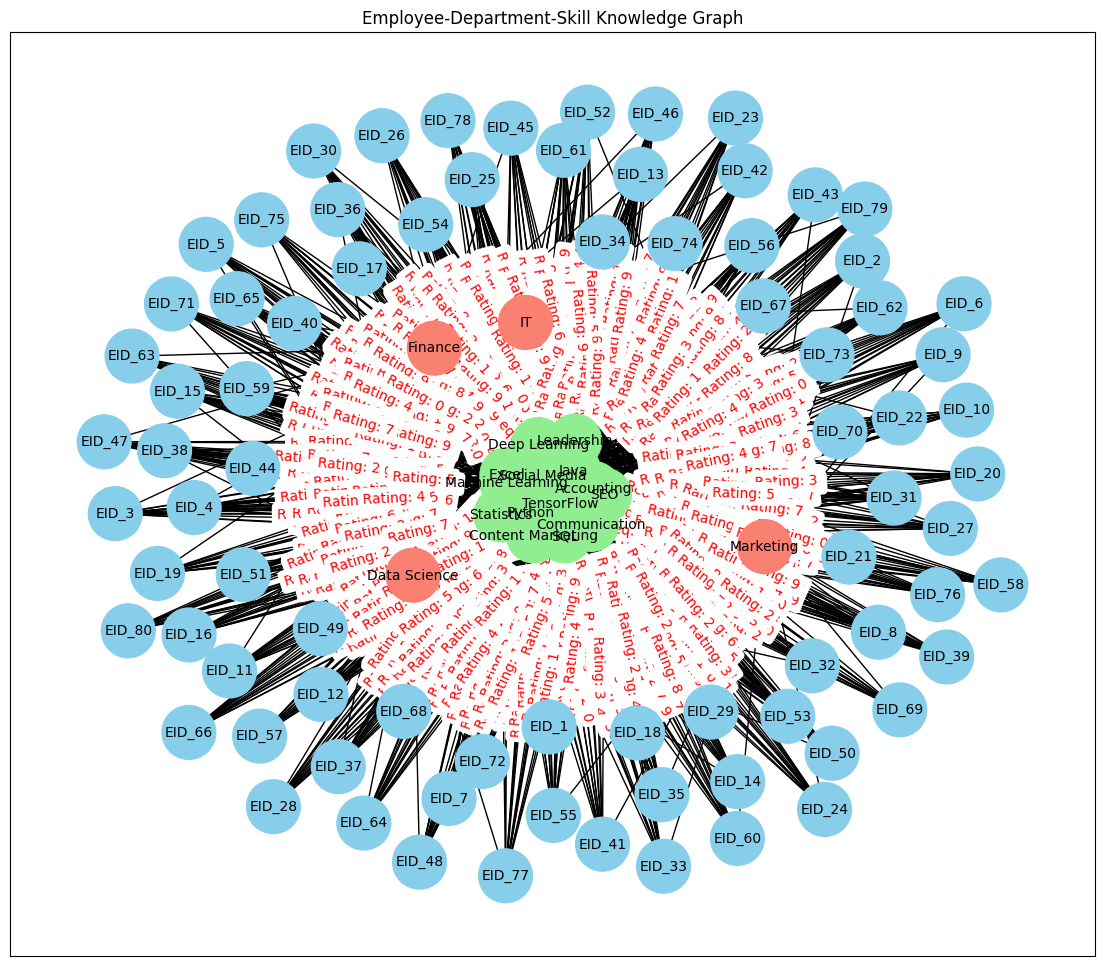

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
G = nx.Graph()

# Add Department nodes
departments = list(average_skill_ratings.keys())
for department in departments:
    G.add_node(department, type='Department')

# Add Skill nodes
skills = set()
for department_skills in average_skill_ratings.values():
    skills.update(department_skills.keys())

for skill in skills:
    G.add_node(skill, type='Skill')

# Add Employee nodes and relationships with skill ratings
for employee in employees_with_ratings:
    G.add_node(employee["name"], type='Employee', experience=employee["experience"], ds_experience=employee["ds_experience"])
    G.add_edge(employee["name"], employee["department"], relationship='WORKS_IN')

    for skill, rating in employee["skills"].items():
        G.add_edge(employee["name"], skill, relationship='HAS_SKILL', rating=rating)

# Add relationships between each department and required skills with average ratings
for department, skill_ratings in average_skill_ratings.items():
    for skill, threshold in skill_ratings.items():
        G.add_edge(department, skill, relationship='NEEDS_SKILL', required_rating=threshold)

# Visualize the Knowledge Graph
plt.figure(figsize=(14, 12))

# Define positions
pos = nx.spring_layout(G, seed=42)

# Draw nodes with different colors based on their type
color_map = {'Employee': 'skyblue', 'Department': 'salmon', 'Skill': 'lightgreen'}
node_colors = [color_map.get(G.nodes[n].get('type', 'Unknown'), 'gray') for n in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edge labels for skill ratings and required ratings
edge_labels = {}
for u, v, d in G.edges(data=True):
    if 'rating' in d:
        edge_labels[(u, v)] = f"Rating: {d['rating']}"
    elif 'required_rating' in d:
        edge_labels[(u, v)] = f"Req: {d['required_rating']}"

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Employee-Department-Skill Knowledge Graph')
plt.show()


In [9]:
def evaluate_candidate_fit(candidate_skills, average_skill_ratings):
    """
    Evaluate the best department fit for a candidate based on their skills.

    :param candidate_skills: Dictionary of the candidate's skills with ratings.
    :param average_skill_ratings: Dictionary of average skill ratings by department.
    :return: Best fit department and details of matching skills, missing skills, and skills to improve.
    """
    best_department = None
    best_match_score = float('-inf')  # Start with the lowest possible score
    best_fit_details = {}

    # Iterate over each department to evaluate the fit
    for department, dept_skills in average_skill_ratings.items():
        matching_skills = {}
        missing_skills = {}
        skills_to_improve = {}

        # Compare candidate skills with department skill requirements
        for skill, required_rating in dept_skills.items():
            if skill in candidate_skills:
                if candidate_skills[skill] >= required_rating:
                    matching_skills[skill] = candidate_skills[skill]
                else:
                    skills_to_improve[skill] = (candidate_skills[skill], required_rating)
            else:
                missing_skills[skill] = required_rating

        # Calculate a match score (number of matching skills minus skills to improve and missing skills)
        match_score = len(matching_skills) - (len(skills_to_improve) + len(missing_skills))

        # Check if this department is a better fit
        if match_score > best_match_score:
            best_match_score = match_score
            best_department = department
            best_fit_details = {
                "matching_skills": matching_skills,
                "missing_skills": missing_skills,
                "skills_to_improve": skills_to_improve
            }

    return best_department, best_fit_details

# Example candidate skills
candidate_skills_example = {"Python": 2, "SQL": 5, "Java": 7, "Excel": 4, "Communication": 5}

# Evaluate the candidate's fit for each department
best_department, best_fit_details = evaluate_candidate_fit(candidate_skills_example, average_skill_ratings)

# Output the best fit department and details
print(f"Best fit department for the candidate: {best_department}")
print()
print("Matching skills:", best_fit_details["matching_skills"])
print()
print("Missing skills:", best_fit_details["missing_skills"])
print()
print("Skills to improve:", {skill: f"Current: {current}, Required: {required}"
                            for skill, (current, required) in best_fit_details["skills_to_improve"].items()})


Best fit department for the candidate: IT

Matching skills: {'SQL': 5, 'Java': 7, 'Excel': 4, 'Communication': 5}

Missing skills: {'Accounting': 4.0, 'SEO': 5.0, 'Content Marketing': 5.0, 'Social Media': 4.0, 'Machine Learning': 5.0, 'Statistics': 4.0, 'TensorFlow': 4.0, 'Deep Learning': 4.0, 'Leadership': 4.0}

Skills to improve: {'Python': 'Current: 2, Required: 4.0'}
